In [1]:
import json
import shutil
from pathlib import Path

In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
LABELS_PATH = Path("labels.json")
FOURIER_COEFFS_DIR = Path("fourier_coeffs")

In [4]:
SAMPLE_SIZE = 4098
SAMPLING_FREQ = 12000

In [5]:
label_map = json.loads(LABELS_PATH.read_text())

In [6]:
label_map

{'0': ['CWRU-dataset-main/Normal'],
 '1': ['CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007'],
 '2': ['CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014'],
 '3': ['CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021'],
 '4': ['CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007'],
 '5': ['CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014'],
 '6': ['CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021'],
 '7': ['CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3',
  'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6',
  'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12'],
 '8': ['CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014'],
 '9': ['CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3',
  'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6',
  'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12']}

In [7]:
if FOURIER_COEFFS_DIR.exists():
    shutil.rmtree(FOURIER_COEFFS_DIR)

In [8]:
def sample(signal, sample_size):
    remainder = len(signal) % sample_size
    signal = signal[:-remainder]
    signal_samples = signal.reshape(-1, sample_size)
    return signal_samples

In [9]:
def transform(signal_samples):
    coeffs_samples = []

    for signal_sample in signal_samples:
        fourier_coeffs = np.abs(np.fft.fft(signal_sample))
        fourier_coeffs = fourier_coeffs[:len(fourier_coeffs) // 2]
        coeffs_samples.append(fourier_coeffs)

    return np.vstack(coeffs_samples)

In [10]:
for label, input_dirs in label_map.items():

    for input_dir in input_dirs:

        for signal_path in Path(input_dir).rglob("*.mat"):
            # Read signal from file
            data = scipy.io.loadmat(str(signal_path))
            signal_name = signal_path.stem
            signal_name, *_, load = signal_name.split("_")
            signal_name, *_ = signal_name.split("@")
            signal = data[f"X{int(signal_name):03}_DE_time"].squeeze()

            # Sample and transform signal to frequency domain
            signal_samples = sample(signal, SAMPLE_SIZE)
            coeffs_samples = transform(signal_samples)

            # Split signal samples for train and test set
            train_coeffs, test_coeffs = train_test_split(coeffs_samples, test_size=0.3)

            # Save train signal
            train_coeffs_path = FOURIER_COEFFS_DIR / "train" / label / f"{load}.mat"
            train_coeffs_path.parent.mkdir(exist_ok=True, parents=True)

            if train_coeffs_path.exists():
                saved_train_coeffs = scipy.io.loadmat(str(train_coeffs_path))["data"]
                train_coeffs = np.concatenate([saved_train_coeffs, train_coeffs], axis=0)

            scipy.io.savemat(str(train_coeffs_path), {"data": train_coeffs})

            # Save test signal
            test_coeffs_path = FOURIER_COEFFS_DIR / "test" / label / f"{load}.mat"
            test_coeffs_path.parent.mkdir(exist_ok=True, parents=True)

            if test_coeffs_path.exists():
                saved_test_coeffs = scipy.io.loadmat(str(test_coeffs_path))["data"]
                test_coeffs = np.concatenate([saved_test_coeffs, test_coeffs], axis=0)

            scipy.io.savemat(str(test_coeffs_path), {"data": test_coeffs})

In [11]:
train_coeffs_path = Path("fourier_coeffs/train/1/0.mat")

In [12]:
data = scipy.io.loadmat(str(train_coeffs_path))["data"]

In [13]:
coeffs_samples = data[:, :SAMPLE_SIZE // 2]

In [14]:
coeffs_samples.shape

(20, 2049)

In [15]:
fourier_coeffs = coeffs_samples[0]

In [16]:
fourier_freqs = np.fft.fftfreq(SAMPLE_SIZE, 1 / SAMPLING_FREQ)
fourier_freqs = fourier_freqs[:SAMPLE_SIZE // 2]

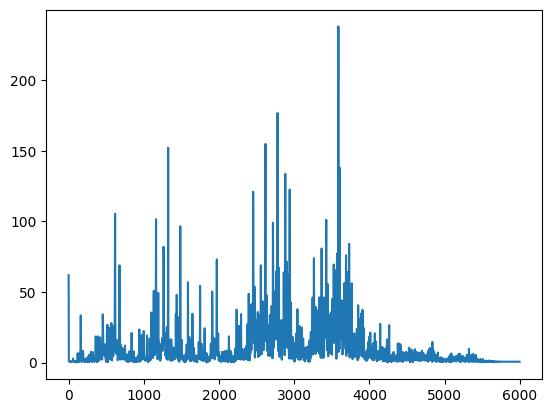

In [17]:
plt.plot(fourier_freqs, fourier_coeffs)